In [56]:
import pandas as pd
# from sqlalchemy import create_engine
import os
import matplotlib.pylab as plt
# db_pass = os.environ['NFL_DB_PASS']
# engine = create_engine('postgresql://postgres:{}@localhost:5432/nfl'.format(db_pass))
pd.options.display.max_rows = 50
pd.options.display.max_columns = 100
%matplotlib inline

# Data Prep
- Adding all the various information about the play to the dataframe

In [333]:
# Read data
ballsnap_pos = pd.read_csv('../working/ballsnap_pos.csv', index_col=0)
print('orig ballsnap shape {}'.format(ballsnap_pos.shape))
pi = pd.read_csv('../input/play_information.csv')

pi.columns = [col.lower() for col in pi.columns]
ballsnap_pos['season_year'] = ballsnap_pos['season_year'].astype('int64')
ballsnap_pos['gamekey'] = ballsnap_pos['gamekey'].astype('int64')
ballsnap_pos['playid'] = ballsnap_pos['playid'].astype('int64')

# Create columns
ballsnap_pos['home_team'] = ballsnap_pos['home_team_visit_team'].str[:3]
ballsnap_pos['visit_team'] = ballsnap_pos['home_team_visit_team'].str[4:]
ballsnap_pos['yardline_int'] = ballsnap_pos['yardline'].str[-2:].astype('int')
ballsnap_pos['x_flipped'] = ballsnap_pos.apply(lambda col: 120-col['x'] if col['poss_team'] == col['home_team'] else col['x'], axis=1)
ballsnap_pos['y_flipped'] = ballsnap_pos.apply(lambda col: 53.3-col['y'] if col['poss_team'] == col['home_team'] else col['y'], axis=1)
ballsnap_pos['left_to_right'] = ballsnap_pos.apply(lambda col: True if col['poss_team'] == col['home_team'] else False, axis=1)


ballsnap_pos = pd.merge(ballsnap_pos, pi) # Merge play information
print('ballsnap shape after merging play info {}'.format(ballsnap_pos.shape))

ppd = pd.read_csv('../input/player_punt_data.csv')
ppd.columns = [col.lower() for col in ppd.columns]
ppd_numbers = ppd.groupby('gsisid')['number'].apply(', '.join).reset_index()
ppd_positions = ppd.groupby('gsisid')['position'].apply(', '.join).reset_index()
ppd_by_gsisid = pd.merge(ppd_numbers, ppd_positions)
ballsnap_pos = pd.merge(ballsnap_pos, ppd_by_gsisid, how='left')
print('ballsnap shape after merging player numbers and position info {}'.format(ballsnap_pos.shape))

pprd = pd.read_csv('../input/play_player_role_data.csv')
pprd.columns = [col.lower() for col in pprd.columns]
ballsnap_pos = pd.merge(ballsnap_pos, pprd, how='left')
print('ballsnap shape after merging player role info {}'.format(ballsnap_pos.shape))

# Role info 
role_info_dict = {'GL': ['Gunner', 'Punting_Team'],
             'GLi': ['Gunner', 'Punting_Team'],
             'GLo': ['Gunner', 'Punting_Team'],
             'GR': ['Gunner', 'Punting_Team'],
             'GRi': ['Gunner', 'Punting_Team'],
             'GRo': ['Gunner', 'Punting_Team'],
             'P': ['Punter', 'Punting_Team'],
             'PC': ['Punter_Protector', 'Punting_Team'],
             'PPR': ['Punter_Protector', 'Punting_Team'],
             'PPRi': ['Punter_Protector', 'Punting_Team'],
             'PPRo': ['Punter_Protector', 'Punting_Team'],
             'PDL1': ['Defensive_Lineman', 'Returning_Team'],
             'PDL2': ['Defensive_Lineman', 'Returning_Team'],
             'PDL3': ['Defensive_Lineman', 'Returning_Team'],
             'PDR1': ['Defensive_Lineman', 'Returning_Team'],
             'PDR2': ['Defensive_Lineman', 'Returning_Team'],
             'PDR3': ['Defensive_Lineman', 'Returning_Team'],
             'PDL5': ['Defensive_Lineman', 'Returning_Team'],
             'PDL6': ['Defensive_Lineman', 'Returning_Team'],
             'PFB': ['PuntFullBack', 'Punting_Team'],
             'PLG': ['Punting_Lineman', 'Punting_Team'],
             'PLL': ['Defensive_Backer', 'Returning_Team'],
             'PLL1': ['Defensive_Backer', 'Returning_Team'],
             'PLL3': ['Defensive_Backer', 'Returning_Team'],
             'PLS': ['Punting_Longsnapper', 'Punting_Team'],
             'PLT': ['Punting_Lineman', 'Punting_Team'],
             'PLW': ['Punting_Wing', 'Punting_Team'],
             'PRW': ['Punting_Wing', 'Punting_Team'],
             'PR': ['Punt_Returner', 'Returning_Team'],
             'PRG': ['Punting_Lineman', 'Punting_Team'],
             'PRT': ['Punting_Lineman', 'Punting_Team'],
             'VLo': ['Jammer', 'Returning_Team'],
             'VR': ['Jammer', 'Returning_Team'],
             'VL': ['Jammer', 'Returning_Team'],
             'VRo': ['Jammer', 'Returning_Team'],
             'VRi': ['Jammer', 'Returning_Team'],
             'VLi': ['Jammer', 'Returning_Team'],
             'PPL': ['Punter_Protector', 'Punting_Team'],
             'PPLo': ['Punter_Protector', 'Punting_Team'],
             'PPLi': ['Punter_Protector', 'Punting_Team'],
             'PLR': ['Defensive_Backer', 'Returning_Team'],
             'PRRo': ['Defensive_Backer', 'Returning_Team'],
             'PDL4': ['Defensive_Lineman', 'Returning_Team'],
             'PDR4': ['Defensive_Lineman', 'Returning_Team'],
             'PLM': ['Defensive_Backer', 'Returning_Team'],
             'PLM1': ['Defensive_Backer', 'Returning_Team'],
             'PLR1': ['Defensive_Backer', 'Returning_Team'],
             'PLR2': ['Defensive_Backer', 'Returning_Team'],
             'PLR3': ['Defensive_Backer', 'Returning_Team'],
             'PLL2': ['Defensive_Backer', 'Returning_Team'],
             'PDM': ['Defensive_Lineman', 'Returning_Team'],
             'PDR5': ['Defensive_Lineman', 'Returning_Team'],
             'PDR6': ['Defensive_Lineman', 'Returning_Team'],
             }
role_info = pd.DataFrame.from_dict(role_info_dict, orient='index', columns=['Generalized_Role','Punting_Returning_Team']).reset_index().rename(columns={'index' : 'role'})
ballsnap_pos = pd.merge(ballsnap_pos, role_info, how='left')
print('ballsnap shape after merging player role details {}'.format(ballsnap_pos.shape))

# Add punt return team colors
ballsnap_pos['Punting_Returning_Team_Color'] = ballsnap_pos.apply(lambda x: "#9b59b6" if x['Punting_Returning_Team'] == 'Punting_Team' else "#3498db", axis=1)

# Add the long snappers x, y positions
ballsnap_pos = pd.merge(ballsnap_pos,
         ballsnap_pos.loc[ballsnap_pos.role == 'PLS'][['season_year','gamekey','playid','x','y']],
         suffixes=('','_long_snapper'), on=['season_year','gamekey','playid'], how='left')

ballsnap_pos['x_relative_ls'] = ballsnap_pos['x_long_snapper'] - ballsnap_pos['x']
ballsnap_pos['y_relative_ls'] = ballsnap_pos['y_long_snapper'] - ballsnap_pos['y']

# Add the long snappers x, y positions
ballsnap_pos = pd.merge(ballsnap_pos,
         ballsnap_pos.loc[ballsnap_pos.role == 'PR'][['season_year','gamekey','playid','x','y']],
         suffixes=('','_punt_returner'), on=['season_year','gamekey','playid'], how='left')

# ballsnap_pos['x_relative_pr'] = ballsnap_pos['x_punt_returner'] - ballsnap_pos['x']
# ballsnap_pos['y_relative_pr'] = ballsnap_pos['y_punt_returner'] - ballsnap_pos['y']

# Determine if play is left to right
ballsnap_pos['left_to_right'] = ballsnap_pos.apply(lambda x: True if x['x_long_snapper'] < x['x_punt_returner'] else False, axis=1)
ballsnap_pos['x_relative_ls_left_to_right'] = ballsnap_pos.apply(lambda x: x['x_relative_ls'] if x['left_to_right'] else -x['x_relative_ls'], axis=1)
ballsnap_pos['y_relative_ls_left_to_right'] = ballsnap_pos.apply(lambda x: x['y_relative_ls'] if x['left_to_right'] else -x['y_relative_ls'], axis=1)

# Video review data
vr = pd.read_csv('../input/video_review.csv')
vr.columns = [col.lower() for col in vr.columns]
vr['primary_partner_gsisid'] = pd.to_numeric(vr['primary_partner_gsisid'].replace('Unclear',np.nan))

ballsnap_pos = pd.merge(ballsnap_pos, vr, how='left', on=['season_year','gamekey','playid'], suffixes=('','_video_review_details'))
ballsnap_pos = pd.merge(ballsnap_pos, vr, how='left', on=['season_year','gamekey','playid','gsisid'], suffixes=('','_hurtplayer'))
ballsnap_pos = pd.merge(ballsnap_pos,
                        vr,
                        how='left',
                        left_on=['season_year','gamekey','playid','gsisid'],
                        right_on=['season_year','gamekey','playid','primary_partner_gsisid'],
                        suffixes=('','_hurtingplayer'))

orig ballsnap shape (143431, 15)
ballsnap shape after merging play info (143431, 27)
ballsnap shape after merging player numbers and position info (143431, 29)
ballsnap shape after merging player role info (143431, 30)
ballsnap shape after merging player role details (143431, 32)


# Function for plotting snap positions

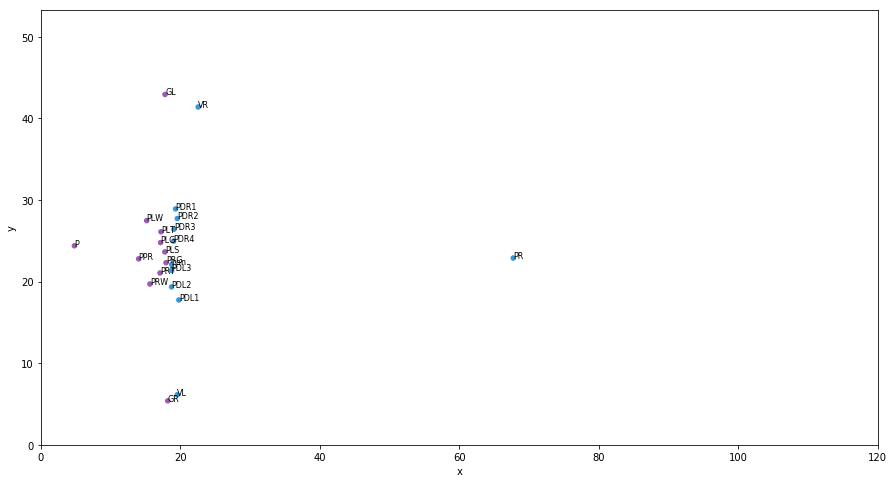

In [248]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']), fontsize=8)


def plot_play_at_snap(df, season_year, gamekey, playid, title='', left_to_right=True):
    play = df.loc[(df['season_year'] == season_year) &
                     (df['gamekey'] == gamekey) &
                     (df['playid'] == playid)].copy()
    if len(play) == 0:
        return 'No play info'

    if left_to_right is False:
        # Invert the x and y values to make it left to right
        play['x'] = 120 - play['x']
        play['y'] = 53.3 - play['y']
    ax = play.plot(kind='scatter', x='x', y='y', figsize=(15, 8), color=play['Punting_Returning_Team_Color'], title=title, xlim=(0,120), ylim=(0,53.3))
    label_point(play.x, play.y, play.role, ax)

def determine_left_to_right(d):
    """
    Given a punter and punt returner position determine if the play
    is going left to right or not
    """
    punter_x = d.loc[d['role'] == 'P']['x'].values[0]
    returner_x = d.loc[d['role'] == 'PR']['x'].values[0]
    if punter_x < returner_x:
        return True
    else:
        return False
        
plot_play_at_snap(ballsnap_pos, 2016, 3, 3949)

## Get plot working on one gamekey

True


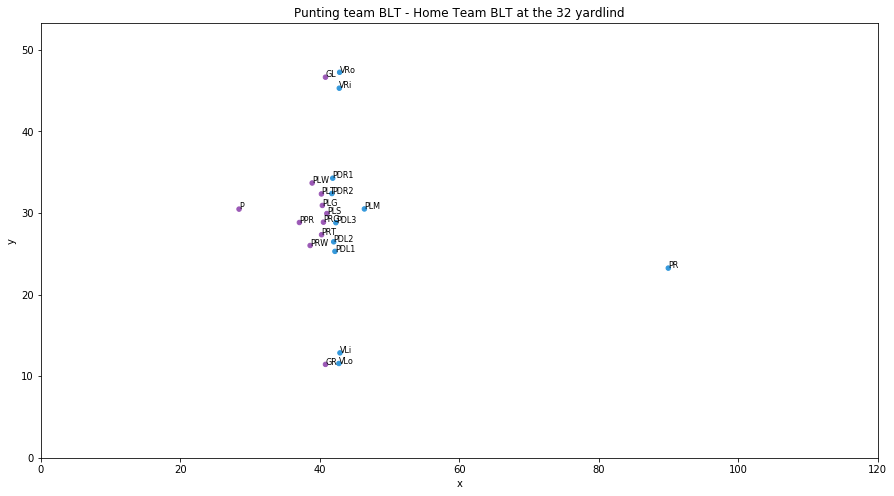

True


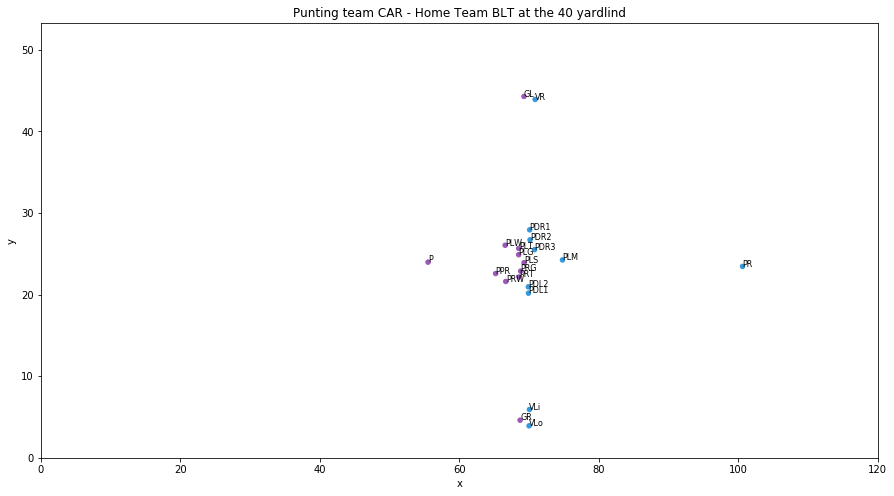

False


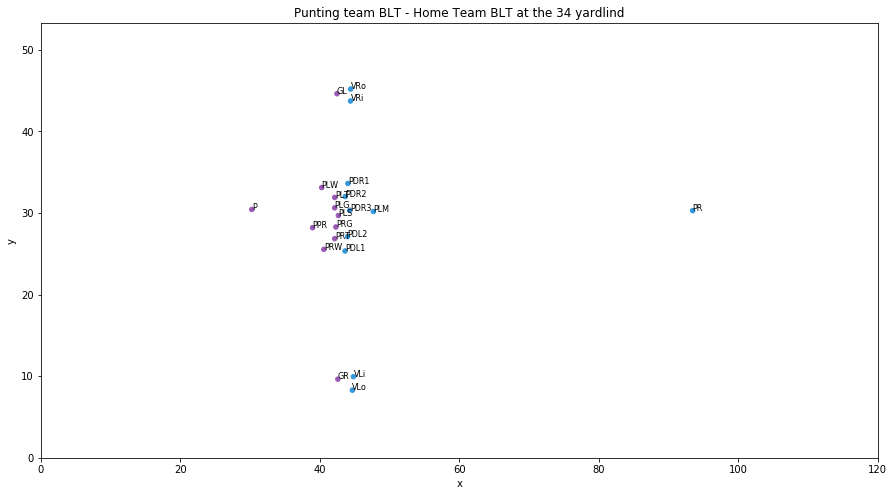

True


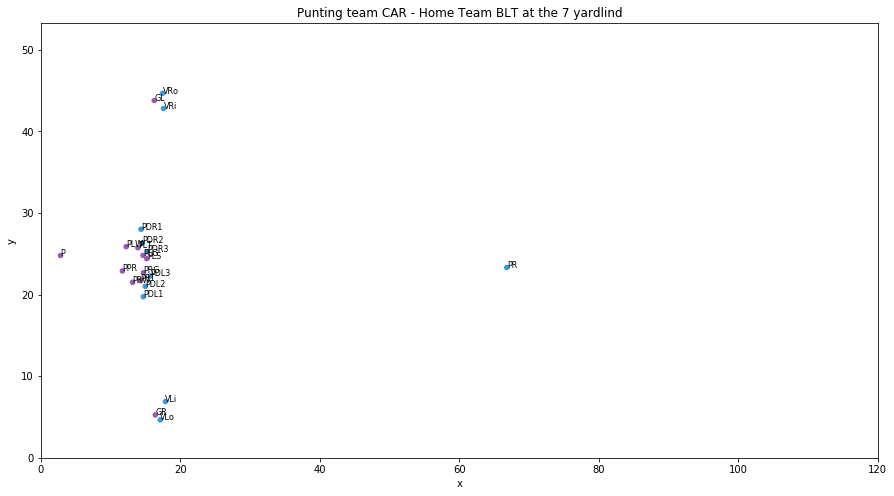

True


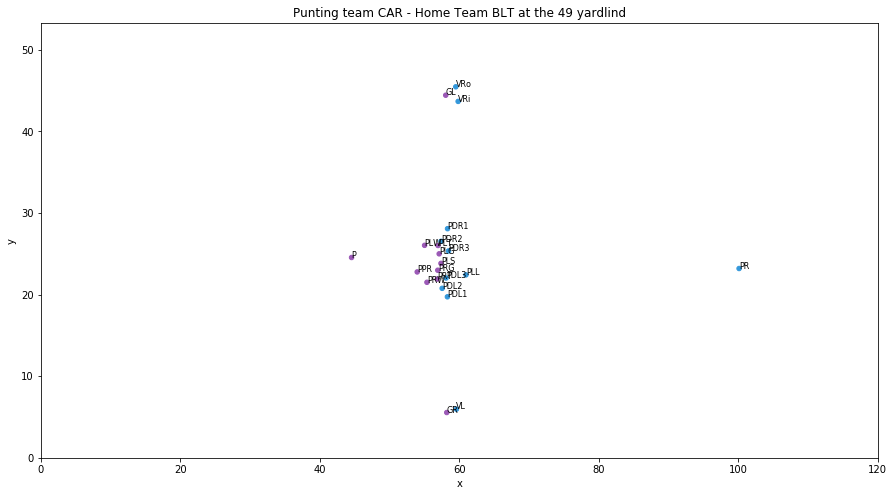

True


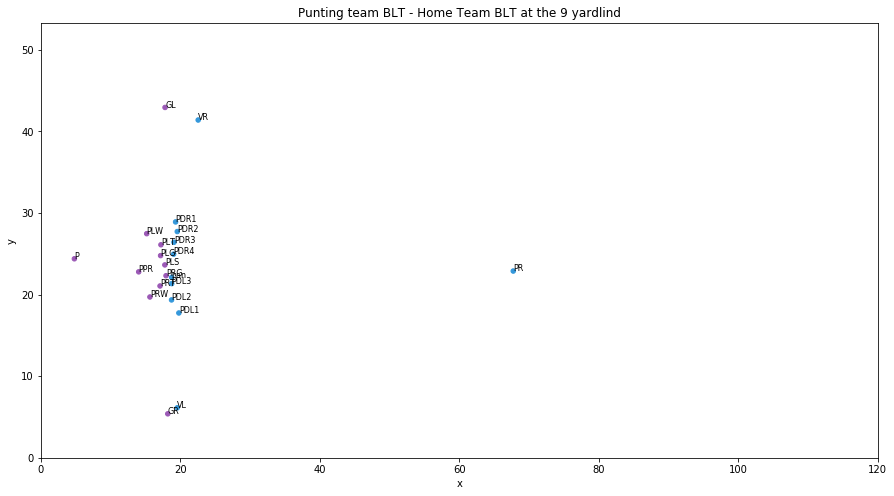

True


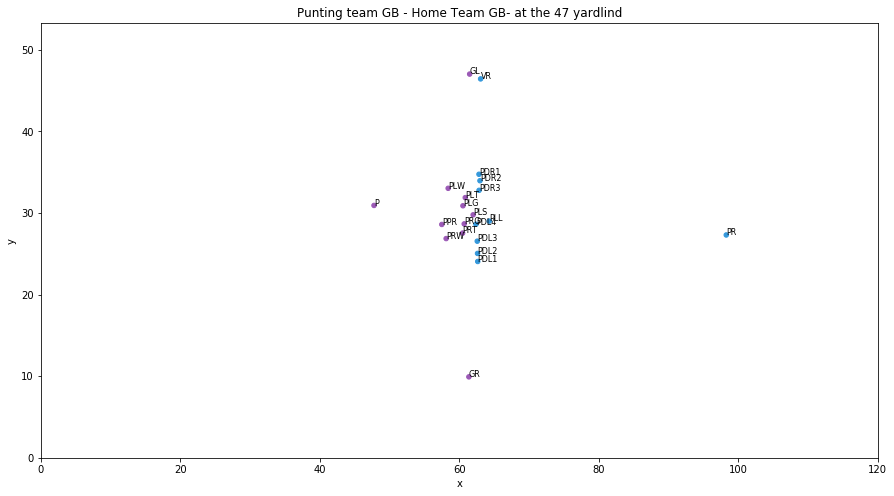

True


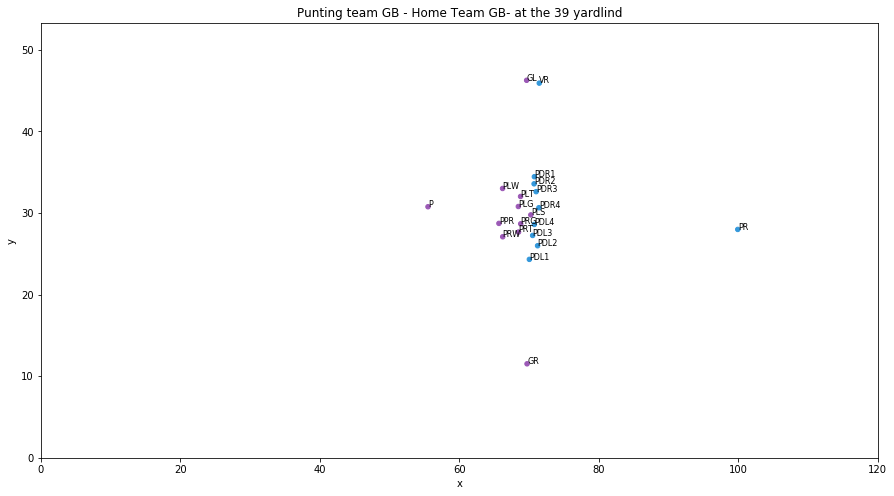

False


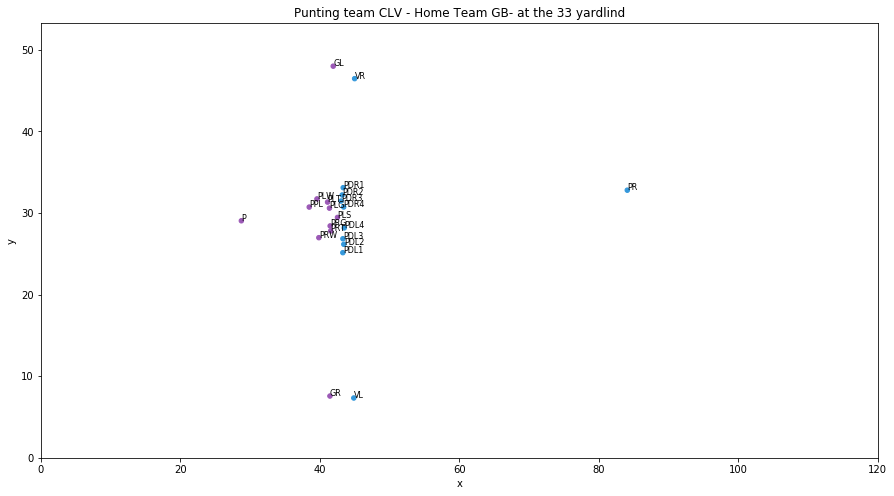

False


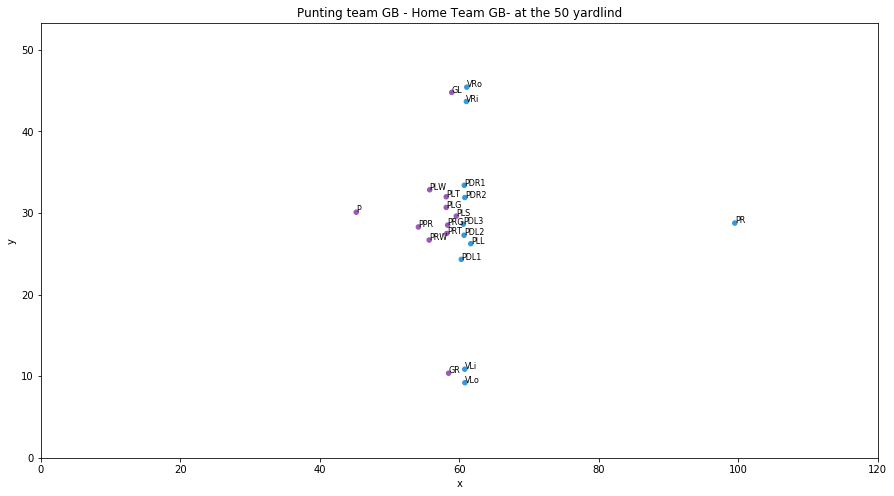

In [249]:
grouped = ballsnap_pos.groupby(['season_year','gamekey','playid'])
count = 0
for i, d in grouped:
    left_to_right = determine_left_to_right(d)
    print(left_to_right)
    count += 1
    poss_team = d['poss_team'].values[0]
    home_team = d['home_team'].values[0]
    yardline_aint = d['yardline_int'].values[0]
    yardline_int = d['yardline_int'].values[0]
    title = 'Punting team {} - Home Team {} at the {} yardlind'.format(poss_team, home_team, yardline_int)
    plot_play_at_snap(ballsnap_pos, i[0], i[1], i[2], title, left_to_right)
    plt.show()
    if count == 10:
        break

# Find player positions relationship to snapper

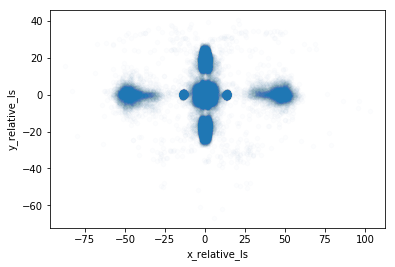

In [283]:
ballsnap_pos.plot(x='x_relative_ls', y='y_relative_ls', kind='scatter', alpha=0.01)

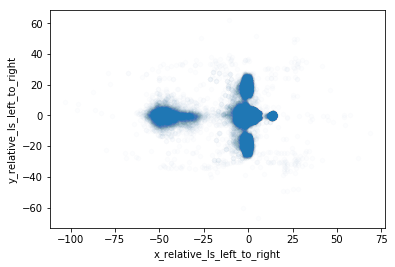

In [293]:
ballsnap_pos.plot(x='x_relative_ls_left_to_right',
                  y='y_relative_ls_left_to_right',
                  kind='scatter',
                  alpha=0.01)

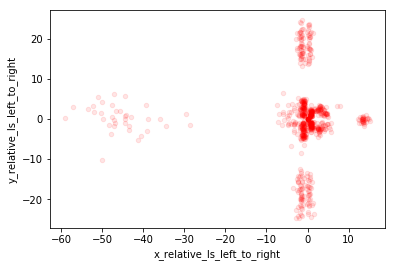

In [307]:
ballsnap_pos.dropna().plot(x='x_relative_ls_left_to_right',
                  y='y_relative_ls_left_to_right',
                  kind='scatter',
                  alpha=0.1,
                          color='r')

# Plot injury plays on top of all snapping position

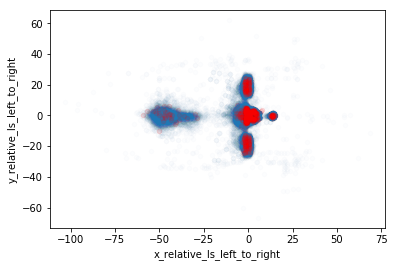

In [315]:
ax = ballsnap_pos.plot(x='x_relative_ls_left_to_right',
                  y='y_relative_ls_left_to_right',
                  kind='scatter',
                  alpha=0.01)
ballsnap_pos[['x_relative_ls_left_to_right',
              'y_relative_ls_left_to_right',
              'primary_partner_gsisid']].dropna().plot(x='x_relative_ls_left_to_right',
                  y='y_relative_ls_left_to_right',
                  kind='scatter',
                  alpha=0.1,
                  color='r', ax=ax)

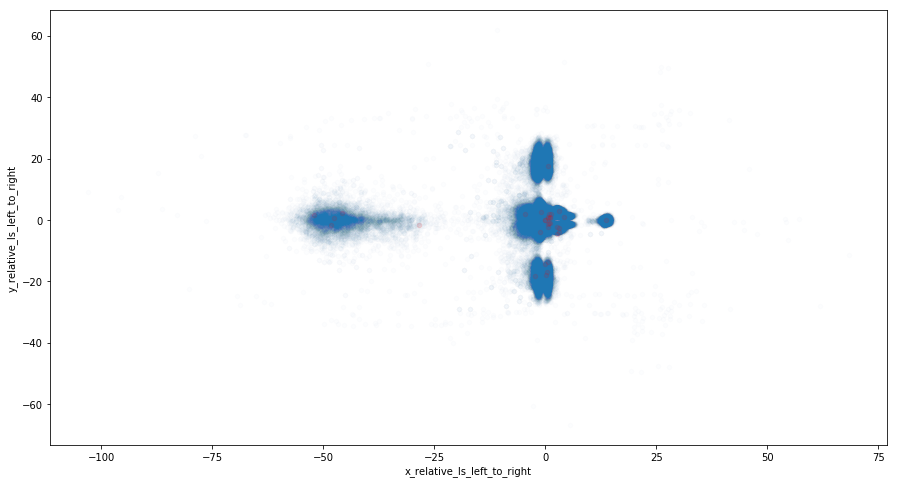

In [338]:
ax = ballsnap_pos.plot(x='x_relative_ls_left_to_right',
                  y='y_relative_ls_left_to_right',
                  kind='scatter',
                  alpha=0.01,
                      figsize=(15, 8))
ballsnap_pos[['x_relative_ls_left_to_right',
              'y_relative_ls_left_to_right',
              'primary_partner_gsisid_hurtplayer']].dropna().plot(x='x_relative_ls_left_to_right',
                  y='y_relative_ls_left_to_right',
                  kind='scatter',
                  alpha=0.1,
                  color='r', ax=ax)

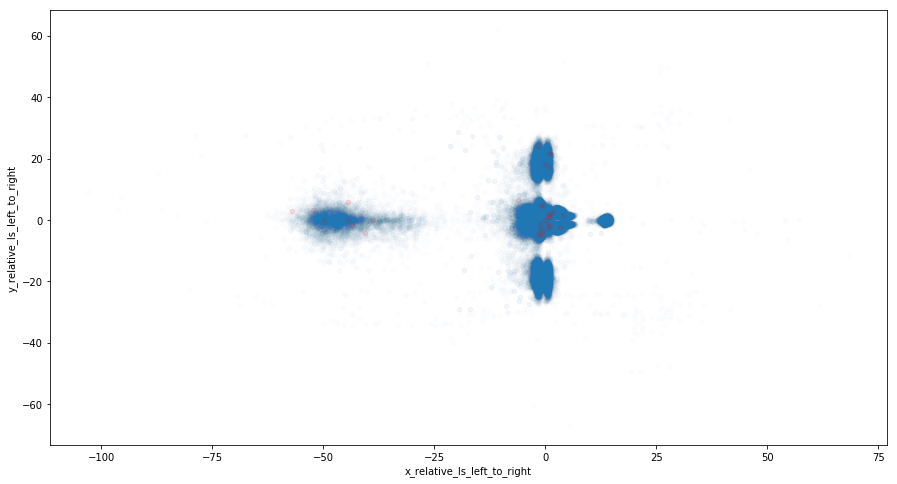

In [337]:
ax = ballsnap_pos.plot(x='x_relative_ls_left_to_right',
                  y='y_relative_ls_left_to_right',
                  kind='scatter',
                  alpha=0.01,
                      figsize=(15, 8))
ballsnap_pos[['x_relative_ls_left_to_right',
              'y_relative_ls_left_to_right',
              'primary_partner_gsisid_hurtingplayer']].dropna().plot(x='x_relative_ls_left_to_right',
                  y='y_relative_ls_left_to_right',
                  kind='scatter',
                  alpha=0.1,
                  color='r', ax=ax)

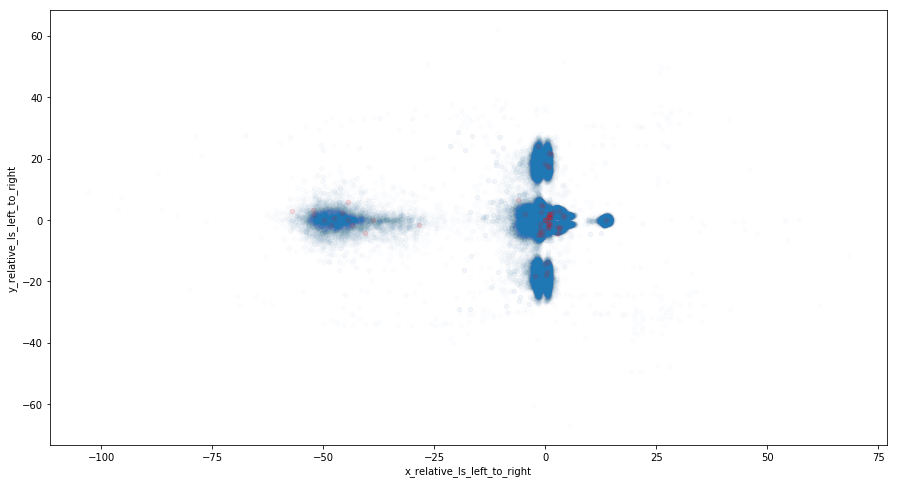

In [341]:
ax = ballsnap_pos.plot(x='x_relative_ls_left_to_right',
                  y='y_relative_ls_left_to_right',
                  kind='scatter',
                  alpha=0.01,
                      figsize=(15, 8))
ballsnap_pos[['x_relative_ls_left_to_right',
              'y_relative_ls_left_to_right',
              'primary_partner_gsisid_hurtplayer']].dropna().plot(x='x_relative_ls_left_to_right',
                  y='y_relative_ls_left_to_right',
                  kind='scatter',
                  alpha=0.1,
                  color='r', ax=ax)
ballsnap_pos[['x_relative_ls_left_to_right',
              'y_relative_ls_left_to_right',
                  y='y_relative_ls_left_to_right',
                  kind='scatter',
                  alpha=0.1,
                  color='r', ax=ax)

In [350]:
ballsnap_pos[['season_year','gamekey','playid','yardline_int','left_to_right','x_long_snapper','y_long_snapper','x_punt_returner','y_punt_returner']].drop_duplicates().reset_index().to_csv('../working/play_direction_snapperloc.csv', index=False)